#### Download the GloVe embeddings data and prepare embedding matrix

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-06-22 13:28:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-22 13:28:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-22 13:28:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [10]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import numpy as np

In [5]:
def process_embeddings(path):
    vocab = []
    idx = 0
    lookup = {}
    vectors = []
    with open(path, 'rb') as f:
        for l in f:
            try:
                line = l.decode().split()
                word = line[0]
                vect = np.array(line[1:]).astype(np.float32) # import numpy as np
                vocab.append(word)
                vectors.append(vect)
                lookup[word] = idx
                idx += 1

            except Exception as e:
                print(e)
    return vocab, lookup, vectors


In [6]:
def build_embedding_matrix(vocab, lookup, vectors):
    num_embeddings = len(vocab) + 2
    embedding_dim = len(vectors[0])
    weights_matrix = np.zeros( (num_embeddings, embedding_dim))
    unknown_index = 1 # Index for words outside of vocab.
    padding_index = 0 # Index for padding token.
    for word in vocab:
        index = lookup[word]
        weights_matrix[index+2] = vectors[index]
    weights_matrix[unknown_index] = np.random.normal(scale=0.6, size=(embedding_dim,))
    weights_matrix[padding_index] = np.zeros( (embedding_dim,))
    print(weights_matrix.shape)
    return weights_matrix

In [7]:
vocab, lookup, vectors = process_embeddings('glove.6B.50d.txt')
glove_embedding_matrix = build_embedding_matrix(vocab, lookup, vectors)

(400002, 50)


In [8]:
glove_embedding_matrix.shape

(400002, 50)

In [9]:
import pandas as pd

In [ ]:
spam_data = pd.read_csv('/content/drive/MyDrive/quora-spam-classification/train.csv', names=['question_text', 'target'], header=0, dtype={'question_text' : str, 'target': np.int32})

In [ ]:
spam_data.head()

,question_text,target
00002165364db923c7e6,How did Quebec nationalists see their province...,0
000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
spam_data['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

#### Balancing the classes

In [ ]:
spam_1_df = spam_data[spam_data['target'] == 1]
spam_0_df = spam_data[spam_data['target'] == 0][:len(spam_1_df)]

In [ ]:
features_non_spam = spam_0_df['question_text'].values
features_spam = spam_1_df['question_text'].values

labels_non_spam = spam_0_df['target'].values
labels_spam = spam_1_df['target'].values

In [ ]:
balanced_features = np.concatenate([features_non_spam, features_spam], axis=0)
balanced_features.shape

(161620,)

In [ ]:
balanced_labels = np.concatenate([labels_non_spam, labels_spam], axis=0)
balanced_labels.shape

(161620,)

In [ ]:
order = np.arange(len(balanced_labels))
np.random.shuffle(order)

balanced_features = balanced_features[order]
balanced_labels = balanced_labels[order]

('I’m a girl, why do girls always be bitchy to me no matter how nice I am and I always get along so much better with boys?',
 0)

#### Split dataset into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(balanced_features,balanced_labels,test_size=0.3,train_size=0.7)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((113134,), (48486,), (113134,), (48486,))

#### Prepare model layers and compile the model.

In [ ]:
import tensorflow as tf

In [ ]:
vectorizer = tf.keras.layers.TextVectorization(max_tokens= len(vocab) + 2, output_mode='int', output_sequence_length=100, vocabulary=vocab)
embedder = tf.keras.layers.Embedding(len(vocab) + 2, 50, embeddings_initializer=tf.keras.initializers.Constant(glove_embedding_matrix), trainable=False)

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens= len(vocab) + 2,
 output_mode='int',
 output_sequence_length=100,
 vocabulary=vocab)


In [ ]:
def build_model(lstm_units=64):
  input_layer = tf.keras.Input(shape=(1,), dtype=tf.string)
  lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units))
  dense_layer = tf.keras.layers.Dense(2*lstm_units, activation='relu')
  output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')

  return tf.keras.Sequential(
      [input_layer,
       vectorizer,
       embedder,
       lstm_layer,
       dense_layer,
       output_layer]
  )

In [ ]:
spam_classifier = build_model()
spam_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 100, 50)           20000100  
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 20,075,621
Trainable params: 75,521
Non-

In [ ]:
spam_classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(1e-4),
                        metrics=['accuracy'])


#### Fit the model on training dataset with cross validation.

In [ ]:
history = spam_classifier.fit(
    x=x_train,
    y=y_train,
    validation_split=0.25,
    epochs=3,
    batch_size=256
)

Epoch 1/3
332/332 [==============================] - 130s 363ms/step - loss: 0.4986 - accuracy: 0.7835 - val_loss: 0.3881 - val_accuracy: 0.8283
Epoch 2/3
332/332 [==============================] - 113s 340ms/step - loss: 0.3799 - accuracy: 0.8333 - val_loss: 0.3658 - val_accuracy: 0.8391
Epoch 3/3
332/332 [==============================] - 113s 340ms/step - loss: 0.3660 - accuracy: 0.8415 - val_loss: 0.3552 - val_accuracy: 0.8456


#### Plot the metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


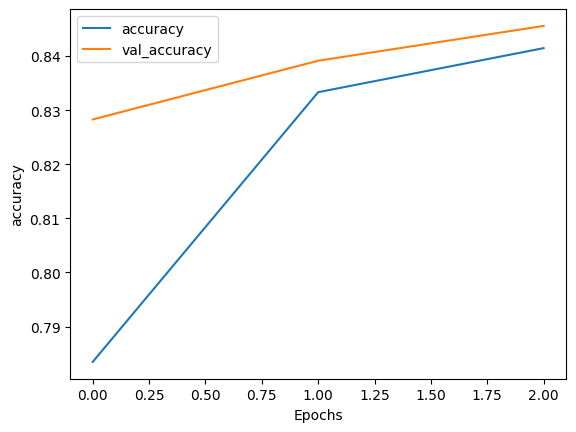

In [ ]:
plot_graphs(history, 'accuracy')

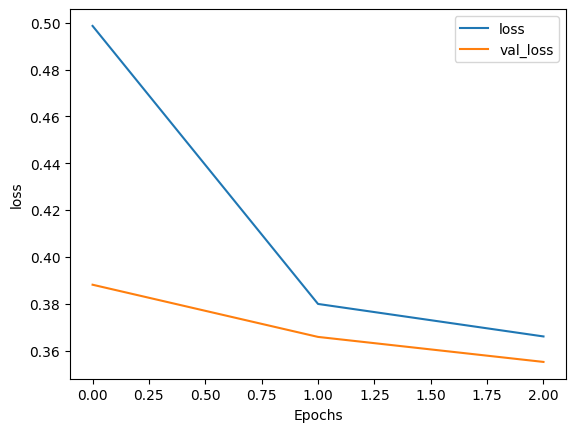

In [ ]:
plot_graphs(history, 'loss')

#### Evaluate on test data

In [ ]:
test_metrics = spam_classifier.evaluate(
    x = x_test,
    y = y_test,
    return_dict=True,
    batch_size=256
)

1531/1531 [==============================] - 503s 329ms/step - loss: 0.1257 - accuracy: 0.9508


In [ ]:
test_metrics

{'loss': 0.12569040060043335, 'accuracy': 0.9507550597190857}

In [ ]:
spam_classifier(np.array(["Are you ashamed of being an Indian?", "How to clean a dirty shoe?"]))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.74161625],
       [0.32267058]], dtype=float32)>